# Image Caption Processing
This notebook will implement image captioning on the Flickr8k dataset.  It is largely based on https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8 and can run in either Google Colab or AWS.

It uses the following data:
- Flickr8k_Dataset.zip (zipped file of 8,000 images from Flickr)
- Flickr8k_text.zip (zipped file of captions to accompany the images and allows for splitting into Train, Test and Validate sets
- /glove.6B.zip (zipped file of GloVE word embeddings)

For Google Colab, it is assumed the data required is in a google My Drive to be mounted below.

For AWS, it is assumed the files have been unzipped onto an AWS server, and resides under /home/ubuntu/datasets

## Google Colab Steps
If running in Google Colab, the steps should be run to link to Google My Drive.

The zipped image and text files are stored in Google My Drive, so first the drive is mounted and then the files are downloaded, accessible in /root/.keras/datasets/

For the files that are persisted, the colab prefix will be set to point back to My Drive.

In [ ]:
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# Read the Images to Keras/datasets
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/Flickr8k_Dataset.zip'
zip_dir = tf.keras.utils.get_file('Flickr8k_Dataset.zip', origin=file_url, extract=True)
print(zip_dir)

# Read the Text files
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/Flickr8k_text.zip'
txt_dir = tf.keras.utils.get_file('Flickr8k_text.zip', origin=file_url, extract=True)
print(txt_dir)

# Read the Text files
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/glove.6B.zip'
glv_dir = tf.keras.utils.get_file('glove.6B.zip', origin=file_url, extract=True)
print(glv_dir)

root_directory = '/root/.keras/datasets/'
colab_prefix = 'drive/My Drive/'

## AWS Setup

If running in AWS, run below for where files are.  The files have been loaded onto the server in /home/ubuntu/datasets/.

Then saving the models, etc. these are just saved in the current directory in AWS.

In [1]:
root_directory = '/home/ubuntu/datasets/'
colab_prefix = ''

# Loading the Data and Cleaning
Read the token file which contains the captions for each image.  There are 5 captions per image.  The structure of the file is:
- Filename
- Caption Number
- Caption

An example is:

`1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .`

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle #import dump, load
from time import time
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, add, Add, concatenate, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = root_directory + "Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)

Then read in the text and split out the filename and description separately.  This goes into a dictionary where the key is the filename and the 5 desciptions are added as the item.


In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


Clean the text by:
- Removing punctuation
- making everything lower case
- remove hanging 's' and 'a'
- remove numbers

In [5]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

Now create a vocabulary of words, so take the descriptions and make a list of unique words.

In [6]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


Then save the descriptions to file.

In [7]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

# Load the Images
trainImages.txt contains the filenames that are to be used for training.  This file is read in, the filetype is stripped off and the filename is saved to a list.

In [8]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = root_directory +  'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
validation = load_set(root_directory +  'Flickr_8k.devImages.txt')
print('Dataset: %d' % len(validation))

Dataset: 6000
Dataset: 1000


Then save a list of images, ready for loading.

In [9]:
# Below path contains all the images
images = root_directory + 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

Now load the set of train image filenames to a list and the set of test image filename to another in preparation of loading the images.

In [10]:
# Below file conatains the names of images to be used in train data
train_images_file = root_directory + 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [11]:
# Below file conatains the names of images to be used in test data
test_images_file = root_directory + 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [12]:
# Below file conatains the names of images to be used in test data
val_images_file = root_directory + 'Flickr_8k.devImages.txt'
# Read the validation image names in a set# Read the test image names in a set
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
val_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in val_images: # Check if the image belongs to test set
        val_img.append(i) # Add it to the list of test images

Load the training descriptions from the file of descriptions created earlier. 'startseq' is added before the caption to denote the start of the sentence and 'endseq' is added at the end to denote the end of the sentence. 


In [13]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
val_descriptions = load_clean_descriptions('descriptions.txt', validation)
print('Descriptions: train=%d' % len(val_descriptions))

Descriptions: train=6000
Descriptions: train=1000


Create a function to preprocess each image for the inception model.  This will load the image in the correct size and format (nimpy array) and scale pixels between -1 and 1.

In [14]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# Feature Extraction
Create an InceptionV3 model as a feature extractor.  This will create a 2,048 element vector as the output.  Since, the top layer is not included, average pooling is applied at the end to convert from a 4D tensor to a 2D tensor.

In [15]:
model_new = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3), pooling='avg')

In [ ]:
model_new.summary()

Below is a function to extract the features of the image.  It will 'predict' on the image to get a 2,048 element output.

In [16]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

The training set images are passed through the inception model to create the features.  The feature set is then saved as pickle file for use later.

In [17]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 414.65667176246643


In [18]:
# Save the bottleneck train features to disk
with open("encoded_train_images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

The Test set images are also passed through the inception model to create their features.  The feature set is then saved as pickle file for use later.

In [19]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 68.95181465148926


In [55]:
# Save the bottleneck test features to disk
with open(colab_prefix + "MG_encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

Create features for the Validation Set.

In [21]:
# Call the funtion to encode all the Validation images - Execute this only once
start = time()
encoding_val= {}
for img in val_img:
    encoding_val[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 69.03615641593933


In [22]:
# Save the bottleneck test features to disk
with open("encoded_val_images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle) 

In [23]:
train_features = pickle.load(open("encoded_train_images1.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
val_features = pickle.load(open("encoded_val_images1.pkl", "rb"))
print('Photos: val=%d' % len(val_features))

Photos: train=6000
Photos: val=1000


The original vocabulary size is 8,763 which includes rare words that do not help in a general model.  So any words that occur less than 10 times are removed.  An extra 'word' in the vocab list is added for '0', because sentences will be padded with 0 to give them a fixed length in processing.

This gives 1652 words for the model's vocabulary.

In [24]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [25]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


Create two dictionaries, one for index to word and one for word to index.  Since the model can only use numeric data, words are converted to a token number and these 2 dictionaries give the mapping from word to token and token to word.

In [26]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [27]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

Calculate the maximum number of words in the training sentences and this will become the length for each sentence.  This length includes the startseq and endseq words we added to each sentence earlier.

In [28]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


print(max_length(val_descriptions))
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: {}'.format(max_length))

31
Description Length: 34


For evaluating later, the word to index, index to word, descriptions and maximum length are all required.  These are saved to a pickle file that cane be reloaded in the bottom, without needing to run through the model again.

In [53]:
# Save wordtoix and ixtoword for evaluation section.
file = open(colab_prefix + 'MG_vocab.pkl','wb')
pickle.dump(wordtoix, file)
pickle.dump(ixtoword, file)
pickle.dump(descriptions, file)
pickle.dump(max_length, file)
file.close()

## Data Generator
A data generator allows data to be processed in batches so that the model does not have to keep all the training data in memeory.  For the RNN, this will have as input the feature vector from the inception model as one input.  The model is predicting the next word in a sequence given the preceding words, so the second input is the increasing sequences of words, for example:
- startseg
- startseg, the
- startseg, the, cat
- startseg, the, cat, is
- startseg, the, cat, is, on
- startseg, the, cat, is, on, the
- startseg, the, cat, is, on, the, grass
- startseg, the, cat, is, on, the, grass, endseq

For each input, the next word is being predicted as Y.

So, the data generator returns the Feature vector, tokens for each increasing sequence and the predictions.

In [30]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y) # No brackets around the outside
                X1, X2, y = list(), list(), list()
                n=0

GloVE word embeddings are used to map each word index to a 200 dimensional vectore, giving an embedding matrix.

In [31]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join(root_directory, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [32]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(1652, 200)

# Model

The model is defined as:
- Image features from InceptionV3 model is input into a dense layer with 256 nodes
- Sentence is input to Embedding Layer
- Embedding layer is input into LSTM with 256 units
- LSTM layer is input into LSTM with 256 units
- LSTM layer is input into LSTM with 256 units
- LSTM output and photo output are added together
- This is fed into a Dense layer 
- Finally this is input into a Dense layer with softmax activation for prediction

In [34]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 =  Dropout(0.5)(se1)
se3 =  LSTM(256, return_sequences=True)(se2)
bn1 = BatchNormalization(axis=-1)(se3)
d1 =  Dropout(0.3)(bn1)
se4 =  LSTM(256, return_sequences=True)(d1)
bn2 = BatchNormalization(axis=-1)(se4)
d2 =  Dropout(0.3)(bn2)
se5 =  LSTM(256)(d2)
decoder1 =  add([fe2, se5])#, axis=1)
decoder2 =  Dense(256, activation='relu')(decoder1)
outputs =  Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

We can load the embedding matrix that was created from the gloVE embeddings as the weights for the embedding layer and then freeze that layer so the weights remain as is.

In [35]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))              

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 34, 200)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 34, 256)      467968      dropout_1[0][0]                  
______________________________________________________________________________________________

In [38]:
epochs = 10
number_pics_per_bath = 64
steps = len(train_descriptions)//number_pics_per_bath
val_steps = len(val_descriptions)//number_pics_per_bath
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))

So that training does not see images in the same order each time, the function below shuffles a dictionary randomly.  This will be called each time for an epoch, improving the training process.

In [39]:
import random

def shuffleTest(train_descriptions):   
   keys =  list(train_descriptions.keys())
   random.shuffle(keys)

   Shuffledtrain_descriptions = {}
   for key in keys:
      Shuffledtrain_descriptions.update({key:train_descriptions[key]})

   return Shuffledtrain_descriptions

In [40]:
for i in range(epochs):
    Shuffledtrain_descriptions = shuffleTest(train_descriptions)
    train_generator = data_generator(Shuffledtrain_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    val_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(x=train_generator, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_generator, validation_steps=val_steps)

93/93 [==============================] - 445s 5s/step - loss: 2.8598 - val_loss: 3.1061


Save the model, so that it can be re-loaded later in the Evaluation phase.

In [54]:
model.save(colab_prefix + 'MeanGirls_BaseLSTM.h5')

# Evaluation and Testing

This section will take the compiled model and run the held out test data against it.  Both Greedy and Beam search have been implemented to assess the quality of the generated captions.

## Google Colab Setup
If running in Google Colab, it will access files from My Drive. 

In [ ]:
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/drive')

colab_prefix = 'drive/My Drive/'
root_directory = '/root/.keras/datasets/'

## AWS Setup
For AWS, there will be no colab prefix and the root directory is set to a datasets directory where the Flickr data is.

In [ ]:
colab_prefix = ''
root_directory = '/home/ubuntu/datasets/'

## Load Data
Once either Google Colab or AWS setup has been run, the below is run through to:
- Setup the libraries
- Re-load the model, encoded test features and Vocabulary data

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle #import dump, load
from time import time

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, add, Add, concatenate, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [42]:
# Load Model from disk
model = tf.keras.models.load_model(colab_prefix + 'MeanGirls_BaseLSTM.h5')

# Load Encoded features of the test set
with open(colab_prefix + "MG_encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

# Load word to index, index to word, descriptions and maximum sentence length from saved values
file = open(colab_prefix + 'MG_vocab.pkl', 'rb')
wordtoix = pickle.load(file)
ixtoword = pickle.load(file)
descriptions = pickle.load(file)
max_length = pickle.load(file)
file.close()

# Set directories
images = root_directory + 'Flicker8k_Dataset/'

## Greedy Search

This function takes the highest probability word predicted at each time step to build the caption description.

In [43]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Beam Search

Beam search is more cpu intensive.  It evaluates multiple sentences by taking the k highest words predicted at each time step and building out those sentences then choosing the best sentence at the end.

Amended from https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

In [44]:
def beamSearch(photo, beam_index = 3):

    start = [wordtoix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([photo, np.array(par_caps)])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Prediction Processing
This function will predict for an image using either Greedy or Beam search.  The results of each picture is saved in a dataframe for analysis later.

In [45]:
# Predict over the test set, either as Greedy or Beam
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction#, sentence_nist, sentence_meteor
def captionPredict(Search = 'Greedy', k=3):
   cc = SmoothingFunction()
   bleu_1 = 0
   bleu_2 = 0
   bleu_3 = 0
   bleu_4 = 0
   i = 0

   results_df = pd.DataFrame(columns=['image_name', 'bleu_1', 'bleu_2', 'bleu_3', 'bleu_4', 'comments', 'caption'])
   nkeep = 5
   pred_good, pred_bad, bleus = [], [], [] 

   for pic in encoding_test.keys():
       image = encoding_test[pic].reshape((1,2048))   
       fname, ext = pic.split('.')

       # Do Prediction either using Greedy or Beam search
       if Search == 'Greedy':
          caption = greedySearch(image) 
       else:
          caption = beamSearch(image, k) 

       predicted = caption.split()
       actual = [d.split() for d in descriptions[fname]]

       i += 1
       if i % 100 == 0:
          print("Processed {} {} {} {} {}".format(i, results_df.loc[:,"bleu_1"].mean(), results_df.loc[:,"bleu_2"].mean(), 
                                                     results_df.loc[:,"bleu_3"].mean(), results_df.loc[:,"bleu_4"].mean()))
       # Evaluate the caption
       bleu = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=cc.method1)
       bleu_1 = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=cc.method1)
       bleu_2 = sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=cc.method1)
       bleu_3 = sentence_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=cc.method1)
       bleu_4 = sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=cc.method1)

       results_df = results_df.append({'image_name': pic, 'bleu_1': bleu_1, 'bleu_2': bleu_2, 
                                       'bleu_3': bleu_3, 'bleu_4': bleu_4, 'comments': descriptions[fname], 
                                       'caption': caption}, ignore_index=True)


       bleus.append(bleu)
       if bleu > 0.8:# and len(pred_good) < nkeep:
           pred_good.append((bleu,pic,descriptions[fname],caption))
       elif bleu < 0.2:# and len(pred_bad) < nkeep:
           pred_bad.append((bleu,pic,descriptions[fname],caption))
  
   print('BLEU-1: {} '.format(results_df.loc[:,"bleu_1"].mean()))
   print('BLEU-2: {} '.format(results_df.loc[:,"bleu_2"].mean()))
   print('BLEU-3: {} '.format(results_df.loc[:,"bleu_3"].mean()))
   print('BLEU-4: {} '.format(results_df.loc[:,"bleu_4"].mean()))

   return results_df

### Predict
Call the above function for either Greedy or Beam.  For Beam, k can be provided.

In [46]:
results_df = captionPredict(Search = 'Greedy')

Processed 100 0.5315151885961501 0.31342322201004624 0.19616101612937506 0.12237501773658029
Processed 200 0.5088609114271183 0.29861711366275606 0.19004691766374282 0.12210209629491407
Processed 300 0.5000865970229241 0.29451767584409383 0.18412611268238588 0.12020566779115581
Processed 400 0.5049045356783142 0.29363323711426415 0.17980581687533156 0.115783778726399
Processed 500 0.5030855086264471 0.28870707042306276 0.17352936817901157 0.1098123339169478
Processed 600 0.5031373598792436 0.2881639159529728 0.1733612023717162 0.10899371156897306
Processed 700 0.5032858165801537 0.29193022737095986 0.17581839663061447 0.11135836422052342
Processed 800 0.5046569049551882 0.29436254477693796 0.17856593537718976 0.11341446996652825
Processed 900 0.5039975405980396 0.29345092985326865 0.1771059860945946 0.11225981440423603
Processed 1000 0.5022227722354323 0.29081757410821457 0.17480473589205106 0.11014142103719117
BLEU-1: 0.5023171090077397 
BLEU-2: 0.29097417619251353 
BLEU-3: 0.17492790

In [47]:
results_df = captionPredict(Search = 'Beam')

Processed 100 0.5131974040321488 0.2986415283953645 0.18327975571541325 0.11724325811507111
Processed 200 0.5117417671523086 0.3112007324933114 0.1934581874660153 0.12355619588171386
Processed 300 0.508657361880561 0.3075534422537427 0.1896585448903293 0.12407069044630341
Processed 400 0.5154821675002953 0.30770746052766385 0.18637639154394256 0.11996720755157385
Processed 500 0.5123266326796612 0.30948527406554094 0.18849313592466888 0.12003114340222948
Processed 600 0.5124271387390792 0.3090700799007223 0.1898794663929859 0.12109782996598122
Processed 700 0.5122342656130214 0.31154368198818067 0.19146812394704846 0.12297559034932372
Processed 800 0.5167457218051642 0.31698786098671605 0.1970982625550777 0.12672393311773092
Processed 900 0.5190707778484741 0.3182599060343081 0.19814392529037492 0.12661646664479717
Processed 1000 0.5161920180079896 0.3160099548112838 0.19534287231164033 0.12456369996520814
BLEU-1: 0.5158186831328387 
BLEU-2: 0.3157427398601199 
BLEU-3: 0.19518499805370

## Display Results
Display a scatterplot of BLEU scores, to see how they are distributed.

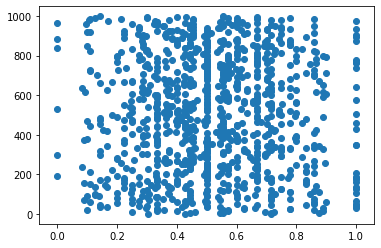

In [48]:
plt.scatter(x=results_df['bleu_1'], y=results_df.index)
plt.savefig(colab_prefix + 'bleu_1.jpg')
plt.show()

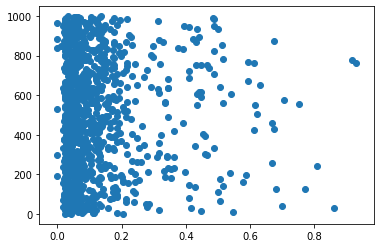

In [49]:
plt.scatter(x=results_df['bleu_4'], y=results_df.index)
plt.savefig(colab_prefix + 'bleu_4.jpg')
plt.show()

## Image Display of True versus Predicted Text
To evaluate images, we can look at how the predicted sentence compares to the 5 true captions.  Below will download the image from My Drive if using colab and then will display either the top or bottom 5 images.

### Google Colab Step to download images

In [ ]:
# Read the Images to Keras/datasets - ONLY FOR Google Colab
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/Flickr8k_Dataset.zip'
zip_dir = tf.keras.utils.get_file('Flickr8k_Dataset.zip', origin=file_url, extract=True)
print(zip_dir)

## Plotting Images and Captions
This function will display a set of images within a range of BLEU scores.  The function is passed:
- Dataframe containing image names, BLEU Scores, predicted sentence and original sentences
- Type of good or bad which shows either the 5 best images or 5 worst images
- Which BLEU score to evaluate on (1 to 4)
- Number of images to display
- If not choosing Good or Bad, a range can be set to see images in that range (eg, show images that scored between 0.4-0.5)

In [50]:
def plot_images(results_df, type='good', bleu_score=1, npic=5, min_range=-1, max_range=1):
    def create_str(caption_true):
        strue = ""
        for s in list(caption_true):
            strue += "\n" + s
        return(strue)

    if type == 'good':
      ascending = False
    else:
      ascending = True
    
    pred_df = results_df.loc[(results_df['bleu_'+str(bleu_score)] >= min_range) & 
                                    (results_df['bleu_'+str(bleu_score)] <= max_range)].sort_values('bleu_'+str(bleu_score),
                                    ascending = ascending).head(npic)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1

    fig = plt.figure(figsize=(10,npic*4))
    for index, row in pred_df.iterrows():

		# take the first token as the image id, the rest as the description

        bleu,pic,actual,caption = row['bleu_'+str(bleu_score)], row['image_name'], row['comments'], row['caption']
        ## images - get image from array, reshape and display in column 1
        image = encoding_test[pic].reshape((1,2048))
        x=plt.imread(images+pic)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(x)
        count += 1
        ## Text - get true descriptions, predicted and BLEU-1 score and display in column 2
        actual = create_str(actual) # Split the 5 descriptions to separate lines
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,1,"photo:" + pic,fontsize=15)
        ax.text(0,0.4,"true:" + actual,fontsize=15)
        ax.text(0,0.2,"pred:" + caption,fontsize=15)
        ax.text(0,0.1,"BLEU-{}: {}".format(bleu_score, bleu),fontsize=15)
        count += 1
        
        print(pic)
        
    plt.savefig(colab_prefix + "{}_{}_{}_{}.jpg".format(type, bleu_score, min_range, max_range)) 
    plt.show()

3459156091_c1879ebe28.jpg
197504190_fd1fc3d4b7.jpg
1394368714_3bc7c19969.jpg
2378149488_648e5deeac.jpg
3360930596_1e75164ce6.jpg


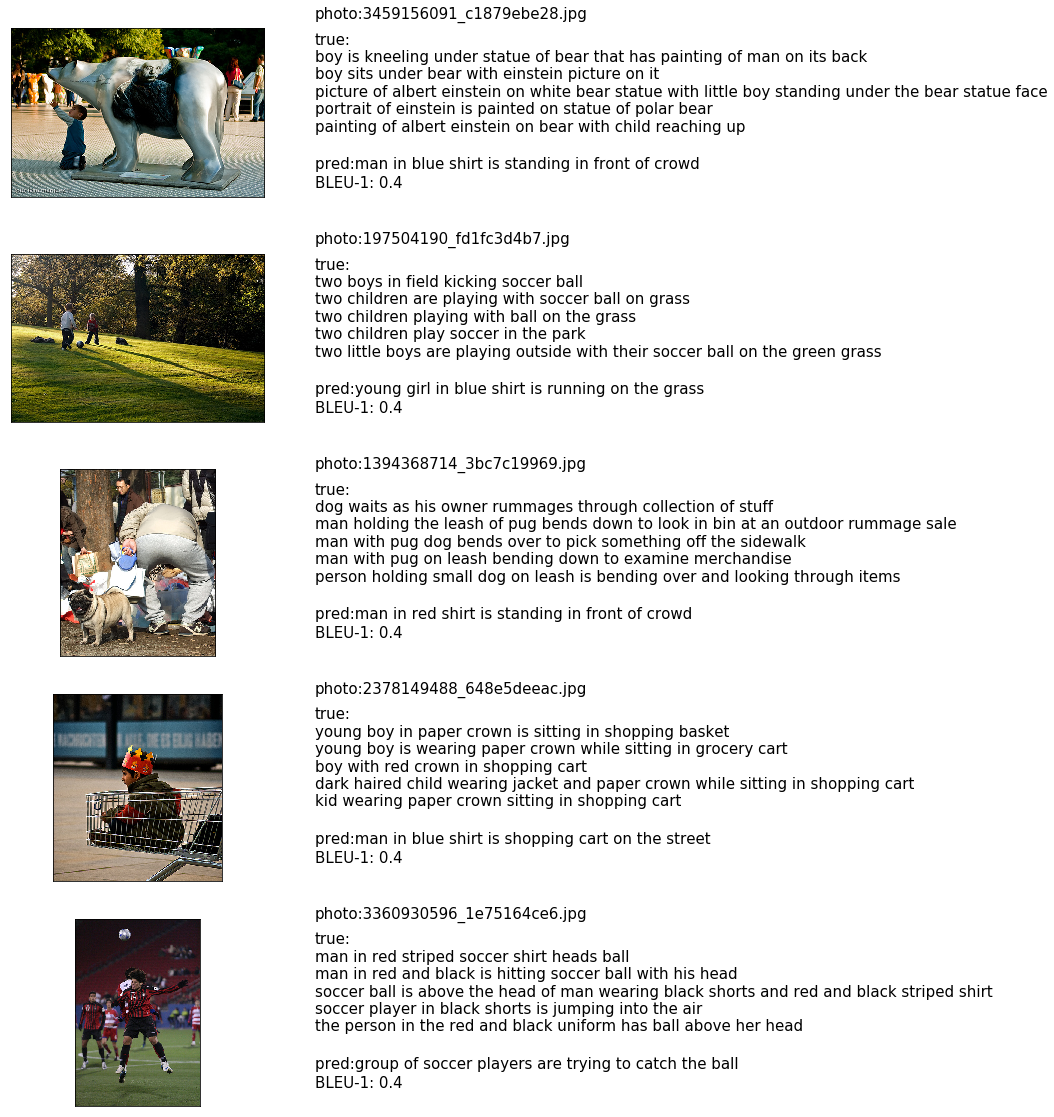

544576742_283b65fa0d.jpg
434792818_56375e203f.jpg
2602085456_d1beebcb29.jpg
363617160_6cb0c723be.jpg
3537400880_8f410d747d.jpg


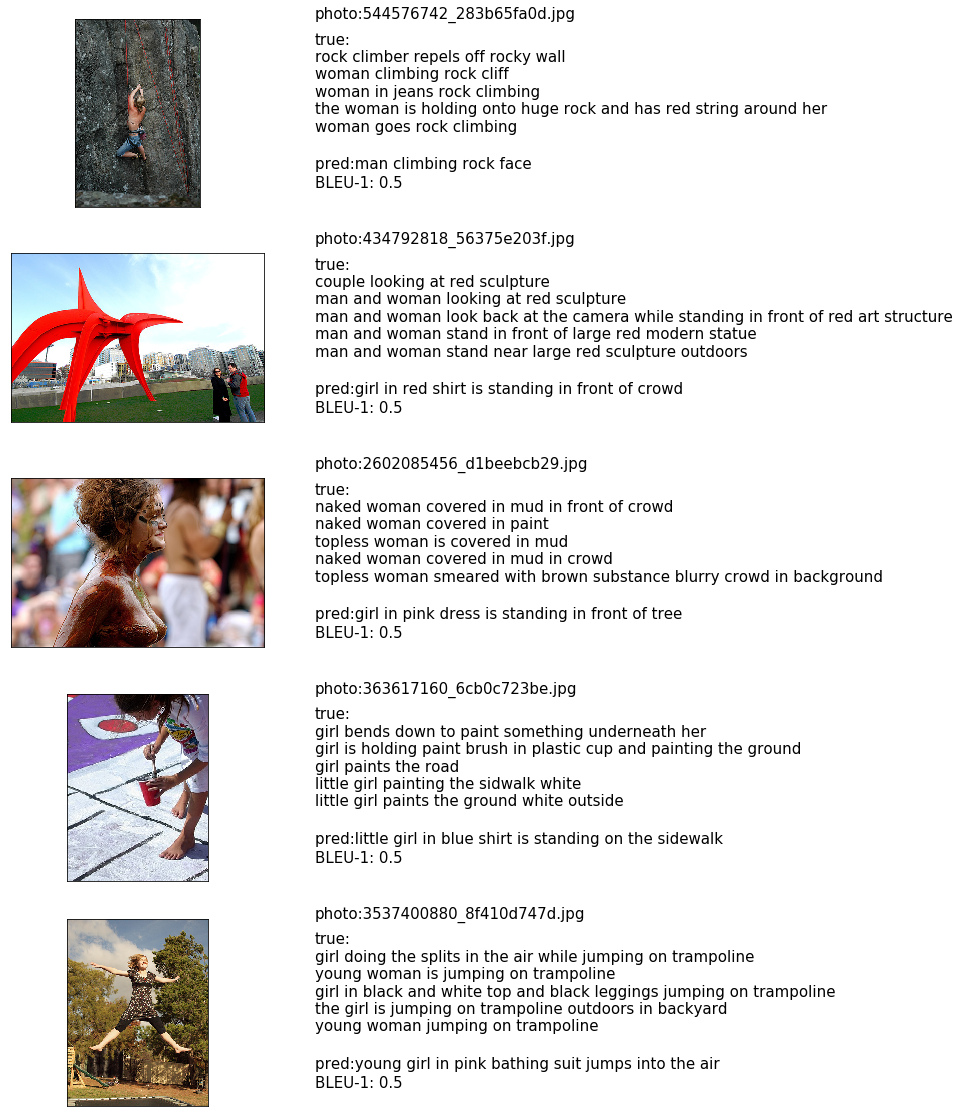

In [57]:
plot_images(results_df, type='bad', bleu_score=1, min_range=0.4, max_range=0.49)
plot_images(results_df, type='bad', bleu_score=1, min_range=0.5, max_range=0.59)


In [ ]:
Ctrl shift i put in console to keep connected
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);